In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e6/sample_submission.csv
/kaggle/input/playground-series-s4e6/train.csv
/kaggle/input/playground-series-s4e6/test.csv


# Loading Library and Data

In [3]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import re

from functools import partial
from scipy.stats import kurtosis, skew, gmean, mode

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer, PowerTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict, RepeatedKFold
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score, r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Ridge, RidgeCV
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC, LinearSVR

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.neural_network import MLPClassifier

import optuna

In [4]:
train = pd.read_csv('../input/playground-series-s4e6/train.csv')
test = pd.read_csv('../input/playground-series-s4e6/test.csv')
submission = pd.read_csv('../input/playground-series-s4e6/sample_submission.csv')

print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)

The dimension of the train dataset is: (76518, 38)
The dimension of the test dataset is: (51012, 37)


In [5]:
train.head()

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,0,1,1,1,9238,1,1,126.0,1,1,19,5,5,122.6,0,0,0,1,0,1,18,0,0,6,6,6,14.500000,0,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,1,17,1,9238,1,1,125.0,1,19,19,9,9,119.8,1,0,0,1,0,0,18,0,0,6,8,4,11.600000,0,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,2,1,17,2,9254,1,1,137.0,1,3,19,2,3,144.7,0,0,0,1,1,0,18,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,3,1,1,3,9500,1,1,131.0,1,19,3,3,2,126.1,1,0,0,1,0,1,18,0,0,7,9,7,12.591250,0,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,4,1,1,2,9500,1,1,132.0,1,19,37,4,9,120.1,1,0,0,1,0,0,18,0,0,7,12,6,12.933333,0,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


In [6]:
test.head()

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,76518,1,1,1,9500,1,1,141.0,1,3,1,2,3,152.1,0,0,0,0,0,0,18,0,0,7,0,0,0.000000,0,0,8,0,0,0.000000,0,13.9,-0.3,0.79
1,76519,1,1,1,9238,1,1,128.0,1,1,19,4,5,116.5,0,0,0,1,0,0,19,0,0,6,7,6,14.857143,0,0,6,6,6,13.500000,0,11.1,0.6,2.02
2,76520,1,1,1,9238,1,1,118.0,1,1,19,4,9,114.2,0,0,0,1,0,1,18,0,0,6,11,6,12.000000,0,0,6,11,5,11.000000,0,15.5,2.8,-4.06
3,76521,1,44,1,9147,1,39,130.0,1,1,19,3,3,130.0,0,0,0,1,0,1,23,0,2,6,15,5,11.500000,0,3,8,14,5,11.000000,0,8.9,1.4,3.51
4,76522,1,39,1,9670,1,1,110.0,1,1,37,5,5,106.0,1,0,0,1,0,0,26,0,0,6,9,3,11.000000,0,0,6,9,4,10.666667,2,7.6,2.6,0.32


In [9]:
print("# of Missing data of train set: ", sum(train.isnull().sum()))
print("# of Missing data of test set:  ", sum(test.isnull().sum()))

# of Missing data of train set:  0
# of Missing data of test set:   0


# Graph

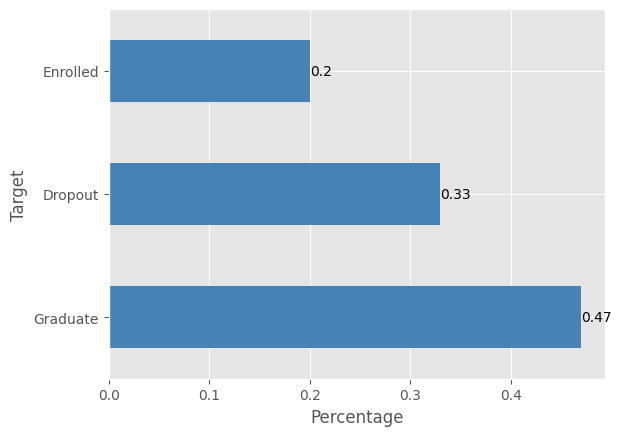

In [10]:
ax = round(train['Target'].value_counts(normalize = True), 2).plot(kind = 'barh', color = 'steelblue')
ax.bar_label(ax.containers[0], label_type = 'edge')
ax.margins(y = 0.1)
plt.xlabel('Percentage');

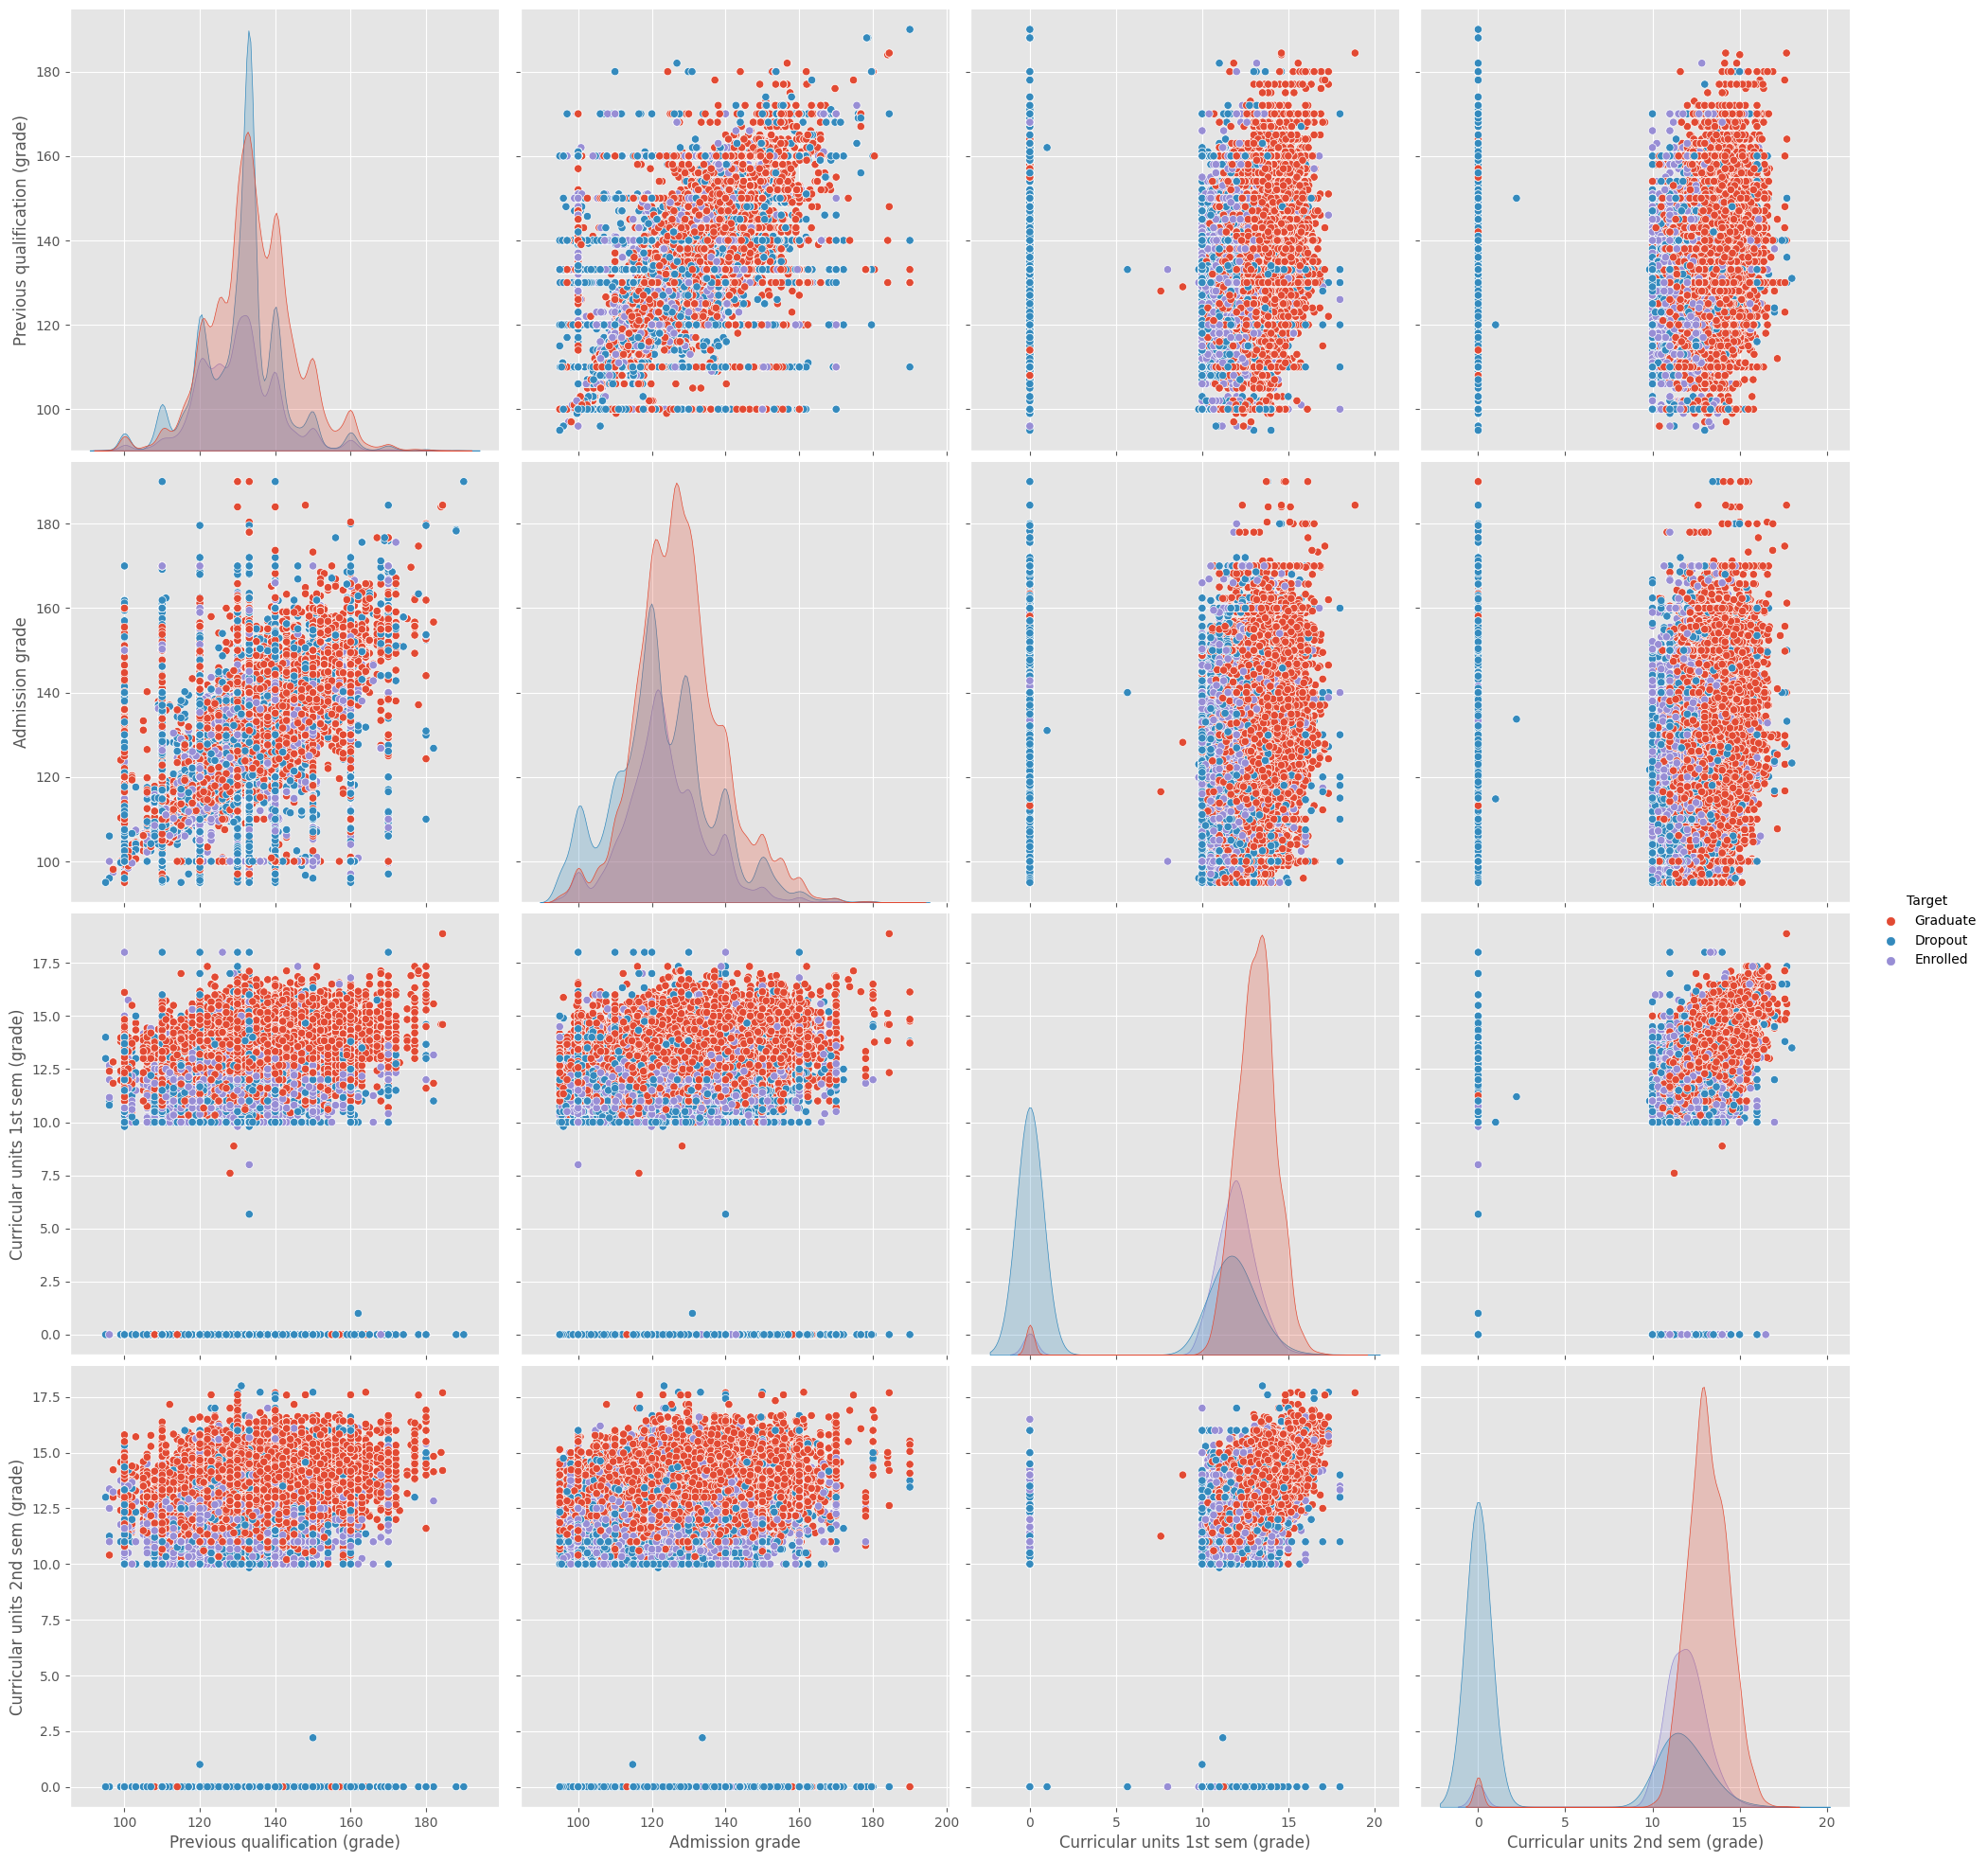

In [11]:
sns.pairplot(data = train[['Previous qualification (grade)', 'Admission grade', 'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)', 'Target']], 
             hue = 'Target', height = 5);

# Data Preprocess

In [12]:
le = LabelEncoder()
le.fit(train['Target'])
train['Target'] = le.transform(train['Target'])

In [13]:
X = train.drop(columns=['id', 'Target'], axis=1)
Y = train['Target']

test_cv = test.drop(columns=['id'], axis=1)

skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=42)
sk = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)

# Model 1: Random Forest

In [14]:
%%time
RF_cv = cross_val_score(RandomForestClassifier(**{'n_estimators': 1259,
                                                  'max_depth': 15,
                                                  'min_samples_split': 4,
                                                  'min_samples_leaf': 2,
                                                  'max_features': 8,
                                                  'max_samples': 0.7788142936534844,
                                                  'random_state': 10,
                                                  'n_jobs': -1}),
                        X, 
                        Y, 
                        scoring='accuracy',
                        cv=skf, 
                        n_jobs=-1)

print(f"The average 10-folds oof accuracy score of the Random Forest model is {RF_cv.mean()}")

The average 10-folds oof accuracy score of the Random Forest model is 0.8267989100161017
CPU times: user 3.04 s, sys: 1.11 s, total: 4.15 s
Wall time: 12min 28s


# Model 2: HistGradientBoosting model

In [15]:
%%time
HGB_cv = cross_val_score(HistGradientBoostingClassifier(**{'l2_regularization': 5.147384283051221,
                                                           'early_stopping': False,
                                                           'learning_rate': 0.021944693910869475,
                                                           'max_iter': 1210,
                                                           'max_depth': 5,
                                                           'max_bins': 226,
                                                           'min_samples_leaf': 10,
                                                           'max_leaf_nodes': 23,
                                                           'random_state': 10}),
                         X, 
                         Y, 
                         scoring='accuracy',
                         cv=skf, 
                         n_jobs=-1)

print(f"The average 10-folds oof accuracy score of the HistGradient model is {HGB_cv.mean()}")

The average 10-folds oof accuracy score of the HistGradient model is 0.8336339311207299
CPU times: user 1.17 s, sys: 532 ms, total: 1.7 s
Wall time: 4min 52s


# Model 3: XGBClassifier

In [ ]:
%%time
XGB_cv = cross_val_score(XGBClassifier(**{'objective': 'multi:softprob',
                                          'tree_method': 'hist',
                                          'num_class': 3,
                                          'max_depth': 8,
                                          'learning_rate': 0.040797444797639554,
                                          'n_estimators': 1748,
                                          'gamma': 0.5631817186746637,
                                          'min_child_weight': 47,
                                          'colsample_bytree': 0.20901565046325682,
                                          'subsample': 0.7312131456978738}),
                         X, 
                         Y, 
                         scoring='accuracy',
                         cv=skf, 
                         n_jobs=-1)

print(f"The average 10-folds oof accuracy score of the XGBoost model is {XGB_cv.mean()}")

# Compare model and Create submission

In [ ]:
model_performance = pd.DataFrame()
model_performance['Model'] = ['RF', 'Hist', 'XGB']
model_performance['10-folds oof Accuracy'] = [RF_cv.mean(), HGB_cv.mean(), XGB_cv.mean()]

print(f"The followig table shows the performance of the considered models: \n\n{model_performance}")

In [ ]:
%%time
XGB_md = XGBClassifier(**{'objective': 'multi:softprob',
                          'tree_method': 'hist',
                          'num_class': 3,
                          'max_depth': 8,
                          'learning_rate': 0.040797444797639554,
                          'n_estimators': 1748,
                          'gamma': 0.5631817186746637,
                          'min_child_weight': 47,
                          'colsample_bytree': 0.20901565046325682,
                          'subsample': 0.7312131456978738}).fit(X, Y)

test_pred = XGB_md.predict(test_cv)

submission['Target'] = le.inverse_transform(test_pred)
submission.head()

In [ ]:
g